# Expected Defensive Rusher Distance to Quarterback

* [Introduction](#section-one)
* [Average play success by closest pass rusher to QB and by time elapsed](#section-two)
    - [Pass Lanes](#subsection-one)
    - [Median Expected Points Added (EPA) Chart](#subsection-two)
    - [Boxplots of 3 DL distribution of distance to QB](#subsection-three)
* [Building the Model](#section-six)
    - [Narrowing the Features](#subsection-seven)
    - [Neural Network](#subsection-eight)
* [Expected Defensive Rusher Distance to QB Metric](#section-three)
    - [Top Defensive Pass Rushers at 2.0, 2.5, 3.0 seconds](#subsection-four)
    - [Offensive Line Team Rankings at 2.0, 2.5, 3.0 seconds](#subsection-five)
    - [Offensive Line Team Rankings by 3rd/4th down and distance](#subsection-six)
* [Appendix](#section-five)

<a id="section-one"></a>
# Introduction

Grading offensive lineman can be very complicated. An offensive tackle may have an incredible game, but one play where a sack is given up may be all that shows up on the stat sheet. If I were employed by a team, I imagine evaluating the offense and defensive lines would be a top priority. My approach would be to work with the experts and try to understand the film grading process by the offensive line coach. At the end of the day, these are the ones with the best idea of how well a lineman performed according to the team's assignments. I'd combine the film grades with a dataset like the one in this competition to train a series of machine learning and deep learning models to see how close we could simulate the film watching process.

Since I don't have access to the grades from the best and the brightest, my strategy is to focus on looking at the distance of the pass rusher to the quarterback on a play. This seems to be a logical first step, since a talented pass rusher would likely be able to break the wall of the offensive lineman's pocket better than others. However, when Aaron Donald is dominating a game, he may begin to be double and triple teamed. If he's still able to get to the QB, that should be more impressive than someone with a wide open lane. I attempt to address this by building a model that predicts how close a pass rusher should get to the QB given the circumstances on a play. The metric I came up with is looking at the expected minus actual distance to a QB by the rusher. This allows for individual pass rushers to be graded on a play, and aggregated throughout the season. Similarly, by taking the expected minus actual distance to the QB for all pass rushers, a team's entire offensive line group can be graded out as well.

<a id="section-two"></a>
# Average play success by closest pass rusher to QB and by time elapsed
### Pass Lanes
The first step in my process was to identify the defensive pass lanes. I attempted to use the gaps between offensive lineman, as referenced below from [banner society](https://www.bannersociety.com/2020/4/21/21083789/football-gaps-holes-numbers-explain).

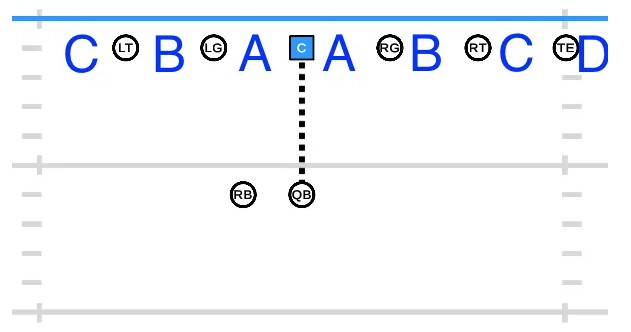

In [1]:
from IPython.display import Image
Image("/kaggle/input/pass-lanes/gaps.jpg")

I tracked the data using the following chart from the defensive lineman's point of view. Starting from 0.6 seconds after the ball is snapped (and assumed to now be in the QB's hands), each blocker and pass rusher is assigned a label based on the region they're in at each tenth of a second. AA stands for the two A gaps, CB is for the C then B gap if coming from the defensive left side, BC is the opposite of CB, and finally LD/RD are the defense's left and right D gaps. This is in relation to the location of the ball. Imagine the ball being at the center of the image, almost like a target, with the pass rushers approaching from the bottom where the pass rush lane labels are. Players are labeled to these areas until the QB throws the ball or is stripped. 

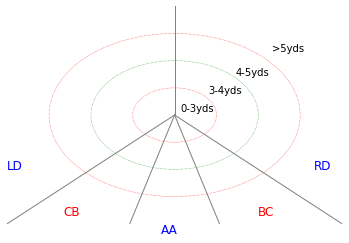

In [2]:
import matplotlib.pyplot as plt
import numpy as np

xy1 = 3.732179
xy2 = 1

x = np.linspace(-100, 100, 1000)

y1 = (xy1)*x
y2 = -(xy1)*x
y3 = (xy2)*x
y4 = -(xy2)*x

# plot
fig, ax = plt.subplots()

ax.plot([-10, 0], [np.interp(-10, x, y1), np.interp(0, x, y1)], linewidth=1.0, color='grey')
ax.plot([0, 10], [np.interp(0, x, y2), np.interp(10, x, y2)], linewidth=1.0, color='grey')
ax.plot([-10, 0], [np.interp(-10, x, y3), np.interp(0, x, y3)], linewidth=1.0, color='grey')
ax.plot([0, 10], [np.interp(0, x, y4), np.interp(10, x, y4)], linewidth=1.0, color='grey')
plt.vlines(x=0, color='grey', linewidth=1.0, ymin=0, ymax=10)

circle1 = plt.Circle((0,0), 0.75, color='r', fill=False, linewidth=0.5, linestyle='dotted')
circle2 = plt.Circle((0,0), 1.5, color='g', fill=False, linewidth=0.5, linestyle='dotted')
circle3 = plt.Circle((0,0), 2.25, color='r', fill=False, linewidth=0.5, linestyle='dotted')

ax.set(xlim=(-3, 3), xticks=np.arange(-3, 3),
       ylim=(-3, 3), yticks=np.arange(-3, 3))
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.grid(False)
plt.axis('off')
plt.text(-.25, -3.25, 'AA', fontsize=12, color='blue')
plt.text(-2, -2.75, 'CB', fontsize=12, color='red')
plt.text(-3, -1.5, 'LD', fontsize=12, color='blue')
plt.text(1.5, -2.75, 'BC', fontsize=12, color='red')
plt.text(2.5, -1.5, 'RD', fontsize=12, color='blue')

plt.text(.1, .1, '0-3yds', fontsize=10)
plt.text(0.6, 0.6, '3-4yds', fontsize=10)
plt.text(1.1, 1.1, '4-5yds', fontsize=10)
plt.text(1.75, 1.75, '>5yds', fontsize=10)

plt.show()

The angle between lines creating the AA border is 30 degrees. The angle between lines creating the CB and BC borders also make a 30 degree angle. The reason for this is looking at the data and the typical starting position of offensive lineman. If the ball is taken four yards behind snap, these lines approximate the inside feet of the guards, and the outside feet of the tackles.

<a id="subsection-two"></a>
### Median Expected Points Added (EPA) Table
Below is a chart taking a look at the location of the closest pass rusher to the QB at 2.0, 2.5, and 3.0 seconds. For each of these three timeframes, I've taken each player's minimum distance from 1.9 - 2.1 seconds, 2.4 - 2.6 seconds, and 2.9 - 3.1 seconds for these labels and called it 2.0, 2.5, and 3.0 seconds. So for example, let's say the closest pass rusher from 1.9 - 2.1 seconds on a play comes from right up the middle and is 3.5 yards from the ball at 2.1 seconds. Such a play would be labeled as being in the '3-4yds' range at '2' seconds. According to the table and the qualifying data for this dataset (for example a pass play has to last at least 2 seconds), this happened 414 times with a median Expected Points Added (EPA) of -0.25.

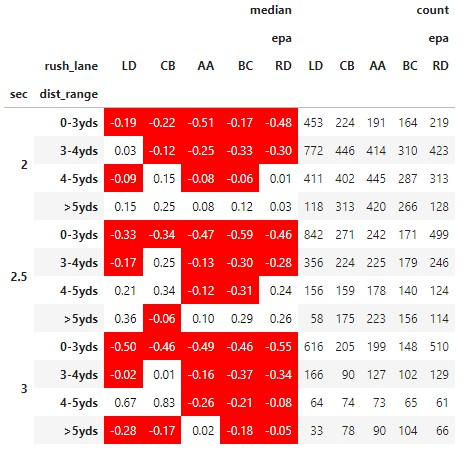

In [3]:
from IPython.display import Image
Image("/kaggle/input/median-epa/median epa.jpg")

<a id="subsection-three"></a>
### Boxplots of 3 DL distribution of distance to QB
Next is a boxplot for 3 defensive tackles. This shows the distribution of distance to the QB at 3 seconds for all qualifying plays in the available dataset.

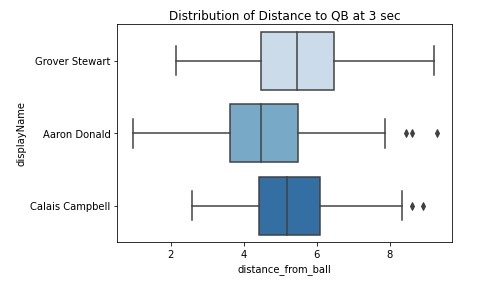

In [4]:
from IPython.display import Image
Image("/kaggle/input/boxplot/Boxplot.jpg")

<a id="section-six"></a>
# Building the Model

<a id="subsection-seven"></a>
### Narrowing the Features

Three separate models were built looking at a series of variables and trying to predict what the pass rusher's distance to the QB should be at 2.0, 2.5, and 3.0 seconds. A sequential forward selection process was used to identify the nine variables that seemed most influential, and are explained in greater detail here:

- start_LD - start_BC: 0 or 1 indicating if the pass rusher came from this pass rushing lane, determined by looking at their position at 0.6 seconds after the ball is snapped
- off_num: How many offensive blockers (as determined by a pff_role = "Pass block") were in the pass rusher's pass lane from 0.6 - 1.5 seconds for 2 second plays, 0.6 - 2.0 seconds for 2.5 second plays, and 0.6 - 2.5 seconds for 3.0 second plays. Can divide this number by the time elapsed to get the average number per second
- total_off_bordering: Essentially the same number as off_num, but shows the total in the neighboring region. For example, if a rusher is in 'AA', how many offensive blockers are in 'CB' or 'BC'. For 'LD' and 'RD', only the inside border is used ('CB' for 'LD' instead of also showing 'RD')
- pff_play_action: 0 or 1 if a playaction play
- Oline: The number of offensive lineman on the play, including tight ends, even if they run a route
- adj_x_distance_from_snap: What is the ball's relative x distance from the location at snap

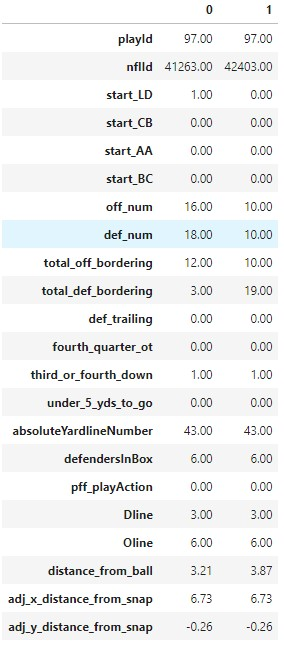

In [5]:
from IPython.display import Image
Image("/kaggle/input/initial-features/Initial Features.jpg")

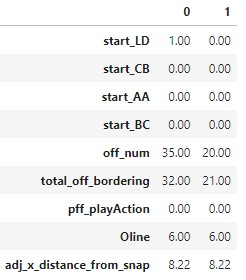

In [6]:
from IPython.display import Image
Image("/kaggle/input/final-features/Final Features.jpg")

<a id="subsection-eight"></a>
### Neural Network
A neural network model was created for each of the three time periods (2.0, 2.5, and 3.0 seconds). It was run for each play using the nine variables found to be most impactful above. With the output of the model, an expected distance to QB total was derived. This total was then subtracted by the actual distance to the QB. A positive number indicates a pass rusher was closer to the QB than expected.

<a id="section-three"></a>
# Expected Defensive Rusher Distance to QB Metric
<a id="subsection-four"></a>
### Top Defensive Pass Rushers at 2.0, 2.5, 3.0 seconds
Below is a list of 84 pass rushers who had over 50 pass rushes in the dataset on pass plays with the QB waiting at least 3 seconds before getting rid of the ball or hit. Using the output of the model, this shows each player's median expected minus actual total, as well as how that total ranks among the 84 rushers for 2.0, 2.5, and 3.0 seconds.

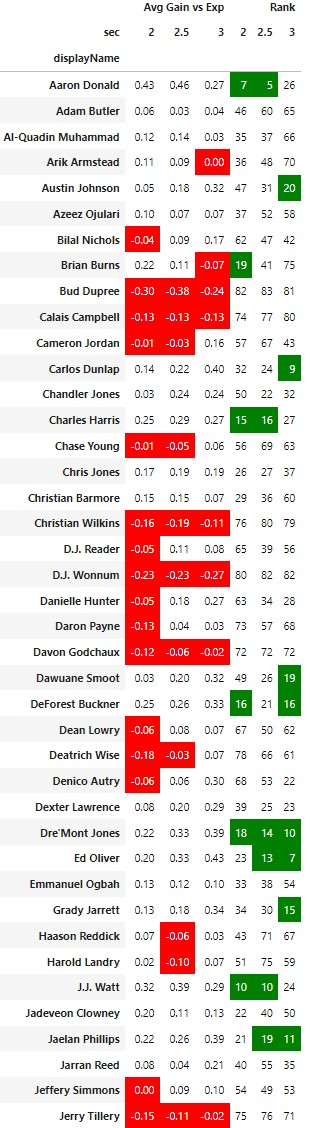

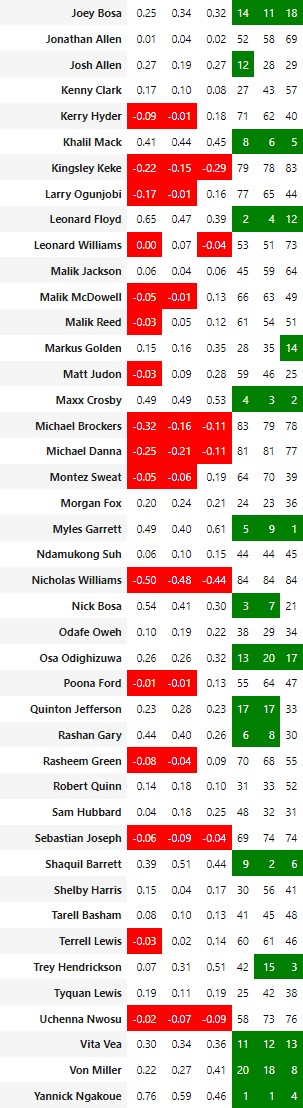

In [7]:
from IPython.display import Image
from IPython.display import display
x = Image("/kaggle/input/ind-rushers/ind rushers 1.jpg") 
y = Image("/kaggle/input/ind-rushers/ind rushers 2.jpg")
display(x,y)

<a id="subsection-five"></a>
### Offensive Line Team Rankings at 2.0, 2.5, 3.0 seconds
Using the expected minus actual data, here are the rankings by offensive line teams. The output is multiplied by (-1) so that a positive number is good for the offense. For each play, the total expected minus actual for each pass rusher is summed and divided by the number of pass rushers to get an average pass rush vs. expected total. Finally, each team's distribution of all plays is looked at, and below shows the median play's average pass rush vs. expected at 2.0, 2.5, and 3.0 seconds. 

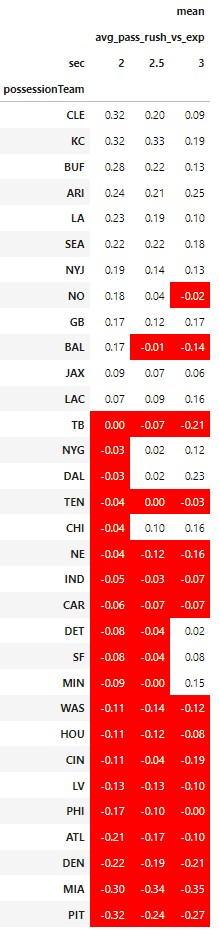

In [8]:
from IPython.display import Image
Image("/kaggle/input/team-oline/team oline avg rank.jpg")

<a id="subsection-six"></a>
### Offensive Line Team Rankings by 3rd/4th down and distance
The final table shows the same offensive line team metric as above, but this is filtered to only show plays that are either on 3rd or 4th down and separated by plays with more than or less than 5 yards to go for a first down.

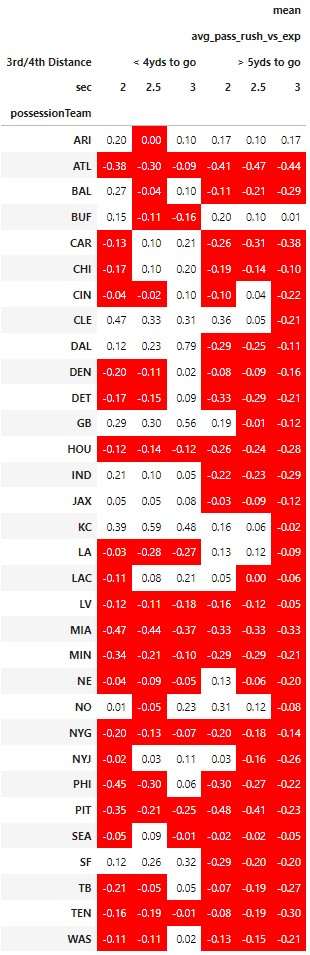

In [9]:
from IPython.display import Image
Image("/kaggle/input/team-oline/team oline avg rank third fourth down.jpg")

<a id="section-five"></a>
# Appendix
All code used for the analysis can be found below, as well as [here](https://github.com/ricdurh/bdb-exp-dist-to-qb). Some next steps would include the following:

- Take a deeper dive into defenders that benefit from rushing next to another great pass rusher.
- Look into how to better account for types of offensive line blocks, and other strategies used to slow down the top pass rushers.
- Offensive line ratings by pass rush lane to see if one side of the line tends to be weaker than the other.
- Offensive line ratings by presnap defensive looks (ex: when the defense is bringing 7 vs. 5 pass blockers, how do teams differ?).

In [10]:
import pandas as pd
import numpy as np
import zipfile
import math
import matplotlib.pyplot as plt


games_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/games.csv')
pff_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv')
players_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/players.csv')
plays_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/plays.csv')

In [11]:
mapping_on_o_d_line = {'C': 'Oline', 'DLT': 'Dline', 'DRT': 'Dline', 'FB': 'NOline',
                      'FB-L': 'NOline', 'FB-R': 'NOline', 'FS': 'NDline', 'FSL': 'NDline', 
                      'FSR': 'NDline', 'HB': 'NOline', 'HB-L': 'NOline', 'HB-R': 'NOline',
                      'LCB': 'NDline', 'LE': 'Dline', 'LEO': 'Dline', 'LG': 'Oline',
                      'LILB': 'NDline', 'LLB': 'NDline', 'LOLB': 'NDline', 'LT': 'Oline',
                      'LWR': 'NOline', 'MLB': 'NDline', 'NLT': 'Dline', 'NRT': 'Dline',
                      'NT': 'Dline', 'QB': 'NOline', 'RCB': 'NDline', 'RE': 'Dline',
                      'REO': 'Dline', 'RG': 'Oline', 'RILB': 'NDline', 'RLB': 'NDline',
                      'ROLB': 'NDline', 'RT': 'Oline', 'RWR': 'NOline', 'SCBiL': 'NDline', 
                      'SCBiR': 'NDline', 'SCBL': 'NDline', 'SCBoL': 'NDline', 'SCBoR': 'NDline',
                      'SCBR': 'NDline', 'SLiWR': 'NOline', 'SLoWR': 'NOline', 'SLWR': 'NOline',
                      'SRiWR': 'NOline', 'SRoWR': 'NOline', 'SRWR': 'NOline', 'SS': 'NDline',
                      'SSL': 'NDline', 'SSR': 'NDline', 'TE-iL': 'Oline', 'TE-iR': 'Oline',
                      'TE-L': 'Oline', 'TE-oL': 'Oline', 'TE-oR': 'Oline', 'TE-R': 'Oline'
}

pff_df['position'] = pff_df['pff_positionLinedUp'].map(mapping_on_o_d_line)

pff = players_df[['nflId', 'displayName']].merge(pff_df[['gameId', 'playId', 'nflId', 'pff_role', 'position']], on='nflId')
games_plays_df = games_df.merge(plays_df, on='gameId')
games_plays_df['def_home'] = np.where(games_plays_df['homeTeamAbbr'] == games_plays_df['defensiveTeam'], 1, -1) 
games_plays_df['def_trailing'] = np.where(((games_plays_df['preSnapHomeScore'] - games_plays_df['preSnapVisitorScore']) * 
                                          games_plays_df['def_home']) < 0 , 1, 0) 
games_plays_df['fourth_quarter_ot'] = np.where(games_plays_df['quarter'] > 3.5, 1, 0)
games_plays_df['third_or_fourth_down'] = np.where((games_plays_df['down'] == 3) | (games_plays_df['down'] == 4), 1, 0)
games_plays_df['under_5_yds_to_go'] = np.where(games_plays_df['yardsToGo'] > 4.5, 1, 0)

In [12]:
plays = games_plays_df[['gameId', 'playId', 'def_trailing', 'fourth_quarter_ot', 'third_or_fourth_down', 
                'under_5_yds_to_go', 'absoluteYardlineNumber', 'defendersInBox', 'pff_playAction', 'playDescription']]
plays_pff = pff.merge(plays, on=['gameId', 'playId'])
plays_pff_count_line = plays_pff[(plays_pff['position'] == 'Dline') | (plays_pff['position'] == 'Oline')].groupby(['gameId',
                'playId', 'def_trailing', 'fourth_quarter_ot', 'third_or_fourth_down', 'under_5_yds_to_go', 
                'absoluteYardlineNumber', 'defendersInBox', 'pff_playAction', 
                'position']).size().unstack(fill_value=0).reset_index()

In [13]:
# weekly movement
week1_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week1.csv')
week2_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week2.csv')
week3_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week3.csv')
week4_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week4.csv')
week5_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week5.csv')
week6_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week6.csv')
week7_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week7.csv')
week8_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/week8.csv')

week_df = [week1_df, week2_df, week3_df, week4_df , week5_df , week6_df , week7_df , week8_df]

week1_df['nflId'] = week1_df['nflId'].fillna(11111)
week1_df['nflId'] = week1_df['nflId'].astype(int)
week2_df['nflId'] = week2_df['nflId'].fillna(11111)
week2_df['nflId'] = week2_df['nflId'].astype(int)
week3_df['nflId'] = week3_df['nflId'].fillna(11111)
week3_df['nflId'] = week3_df['nflId'].astype(int)
week4_df['nflId'] = week4_df['nflId'].fillna(11111)
week4_df['nflId'] = week4_df['nflId'].astype(int)
week5_df['nflId'] = week5_df['nflId'].fillna(11111)
week5_df['nflId'] = week5_df['nflId'].astype(int)
week6_df['nflId'] = week6_df['nflId'].fillna(11111)
week6_df['nflId'] = week6_df['nflId'].astype(int)
week7_df['nflId'] = week7_df['nflId'].fillna(11111)
week7_df['nflId'] = week7_df['nflId'].astype(int)
week8_df['nflId'] = week8_df['nflId'].fillna(11111)
week8_df['nflId'] = week8_df['nflId'].astype(int)

for df in week_df:
    df['nflId'] = df['nflId'].fillna(11111)
    df['jerseyNumber'] = df['jerseyNumber'].fillna(11111)
    df['nflId'] = df['nflId'].astype(int)
    df['jerseyNumber'] = df['jerseyNumber'].astype(int)
    
week_df_2 = pd.concat(week_df)
week_df_2 = week_df_2.drop(columns=['s', 'a', 'dis', 'o', 'jerseyNumber', 'time'])

# weird ball movement play removed from Vikings Game
weekly_df = week_df_2[(week_df_2['gameId'] != 2021091203) & (week_df_2['playId'] != 1041)]

def distance_from_ball(row):
    return math.sqrt(((row['x_ball'] - row['x'])**2) + ((row['y_ball'] - row['y'])**2))

In [14]:
# ball location
ball_loc = weekly_df[weekly_df['nflId'] == 11111]
ball_loc = ball_loc[['gameId', 'playId', 'frameId', 'x', 'y']]

# dataframe for ball location
ball_df = weekly_df.merge(ball_loc, on=['gameId', 'playId', 'frameId'], suffixes=(None, '_ball'))
ball_df['distance_from_ball'] = ball_df.apply(distance_from_ball, axis=1)

In [15]:
ball_snap_frame = ball_df[ball_df['event'] == 'ball_snap'][['gameId', 'playId', 'nflId', 'frameId', 'x_ball', 'y_ball']]
ball_df_2 = ball_df.merge(ball_snap_frame, on=['gameId', 'playId', 'nflId'], suffixes=(None, '_ball_snap'))
ball_df_2['sec_from_ball_snap'] = round((ball_df_2['frameId'] - ball_df_2['frameId_ball_snap'])/10,1)

ball_df_2['x_ball_dist_from_snap'] = round((ball_df_2['x_ball'] - ball_df_2['x_ball_ball_snap']),4)
ball_df_2['y_ball_dist_from_snap'] = round((ball_df_2['y_ball'] - ball_df_2['y_ball_ball_snap']),4)

In [16]:
# Identify plays with passes and sacks to eventually stop play's data
stop_events = ball_df_2[(ball_df_2['event'] == 'pass_forward') | (ball_df_2['event'] == 'autoevent_passforward') |
                        (ball_df_2['event'] == 'qb_sack') |
                        (ball_df_2['event'] == 'qb_strip_sack')][['gameId', 'playId', 'sec_from_ball_snap']]
stop_events_2 = stop_events.drop_duplicates().reset_index(drop=True)

min_time_stop_events = stop_events_2.loc[stop_events_2.reset_index().groupby(['gameId', 
                                                                              'playId'])['sec_from_ball_snap'].idxmin()]
play_time = ball_df_2.loc[ball_df_2.reset_index().groupby(['gameId', 'playId'])['sec_from_ball_snap'].idxmax()]
total_play_time = play_time[['gameId', 'playId','sec_from_ball_snap']].reset_index(drop=True)

play_stop_events_max_time = total_play_time.merge(min_time_stop_events, on=['gameId', 'playId'], how='left')
play_time_events = play_stop_events_max_time.rename({'sec_from_ball_snap_x': 'play_time', 
                                                     'sec_from_ball_snap_y': 'event_time'}, axis=1)
# replace missing event times with value above 2 seconds
play_time_events['event_time'] = play_time_events['event_time'].mask(play_time_events['event_time'].isna(),
                                                                     play_time_events['play_time'])

In [17]:
ball_df_3 = ball_df_2.merge(play_time_events, on=['gameId', 'playId'])
ball_df_3['time_from_stop_event'] = ball_df_3['event_time'] - ball_df_3['sec_from_ball_snap']

ball_df_3['two_sec_play'] = np.where((ball_df_3['play_time'] > 1.85) & (ball_df_3['event_time'] > 2.15) &
                                     (ball_df_3['time_from_stop_event'] > -.05), 1, 0)
ball_df_3['two_half_sec_play'] = np.where((ball_df_3['play_time'] > 2.35) & (ball_df_3['event_time'] > 2.65) &
                                     (ball_df_3['time_from_stop_event'] > -.05), 1, 0)
ball_df_3['three_sec_play'] = np.where((ball_df_3['play_time'] > 2.85) & (ball_df_3['event_time'] > 3.15) &
                                     (ball_df_3['time_from_stop_event'] > -.05), 1, 0)

In [18]:
ball_df_3[['gameId', 'playId', 'frameId', 'frameId_ball_snap']] = ball_df_3[['gameId',
                                                                             'playId', 'frameId',
                                                                             'frameId_ball_snap']].astype(np.int32)

In [19]:
ball_df_3[['x', 'y', 'dir', 'x_ball', 'y_ball', 'distance_from_ball', 'x_ball_ball_snap', 'y_ball_ball_snap', 
          'sec_from_ball_snap', 'x_ball_dist_from_snap', 'y_ball_dist_from_snap', 'play_time', 'event_time',
          'time_from_stop_event']] = ball_df_3[['x', 'y', 'dir', 'x_ball', 'y_ball', 'distance_from_ball',
                                                'x_ball_ball_snap', 'y_ball_ball_snap', 'sec_from_ball_snap',
                                                'x_ball_dist_from_snap', 'y_ball_dist_from_snap', 'play_time',
                                                'event_time', 'time_from_stop_event']].astype(np.float32)

In [20]:
ball_df_4 = ball_df_3[(ball_df_3['sec_from_ball_snap'] > -.15) & (ball_df_3['sec_from_ball_snap'] < 3.15)]

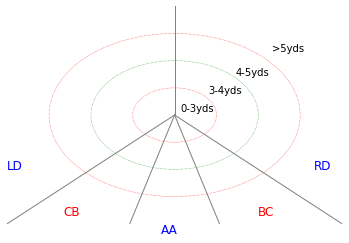

In [21]:
import matplotlib.pyplot as plt
import numpy as np

xy1 = 3.732179
xy2 = 1

x = np.linspace(-100, 100, 1000)

y1 = (xy1)*x
y2 = -(xy1)*x
y3 = (xy2)*x
y4 = -(xy2)*x

# plot
fig, ax = plt.subplots()

ax.plot([-10, 0], [np.interp(-10, x, y1), np.interp(0, x, y1)], linewidth=1.0, color='grey')
ax.plot([0, 10], [np.interp(0, x, y2), np.interp(10, x, y2)], linewidth=1.0, color='grey')
ax.plot([-10, 0], [np.interp(-10, x, y3), np.interp(0, x, y3)], linewidth=1.0, color='grey')
ax.plot([0, 10], [np.interp(0, x, y4), np.interp(10, x, y4)], linewidth=1.0, color='grey')
plt.vlines(x=0, color='grey', linewidth=1.0, ymin=0, ymax=10)
# ax.plot([0, 10], [y2[0], y2[10]], linewidth=2.0)
# ax.plot([-10, 0], [y3[-10], y3[0]], linewidth=2.0)
# ax.plot([0, 10], [y4[0], y4[10]], linewidth=2.0)



circle1 = plt.Circle((0,0), 0.75, color='r', fill=False, linewidth=0.5, linestyle='dotted')
circle2 = plt.Circle((0,0), 1.5, color='g', fill=False, linewidth=0.5, linestyle='dotted')
circle3 = plt.Circle((0,0), 2.25, color='r', fill=False, linewidth=0.5, linestyle='dotted')

ax.set(xlim=(-3, 3), xticks=np.arange(-3, 3),
       ylim=(-3, 3), yticks=np.arange(-3, 3))
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.grid(False)
plt.axis('off')
plt.text(-.25, -3.25, 'AA', fontsize=12, color='blue')
plt.text(-2, -2.75, 'CB', fontsize=12, color='red')
plt.text(-3, -1.5, 'LD', fontsize=12, color='blue')
plt.text(1.5, -2.75, 'BC', fontsize=12, color='red')
plt.text(2.5, -1.5, 'RD', fontsize=12, color='blue')

plt.text(.1, .1, '0-3yds', fontsize=10)
plt.text(0.6, 0.6, '3-4yds', fontsize=10)
plt.text(1.1, 1.1, '4-5yds', fontsize=10)
plt.text(1.75, 1.75, '>5yds', fontsize=10)

plt.show()



# formula to assign players to regions
def which_region(xx, yy, distance):
    
    y1 = (xy1)*x
    y2 = -(xy1)*x
    y3 = (xy2)*x
    y4 = -(xy2)*x
    
    if (yy <= np.interp(xx, x, y1)) & (yy <= np.interp(xx, x, y2)):
        area = 'AA'
    elif (yy <= np.interp(xx, x, y3)) & (yy > np.interp(xx, x, y1)):
        area = 'CB'
    elif (xx < 0) & (yy > np.interp(xx, x, y3)):
        area = 'LD'
    elif (xx > 0) & (yy > np.interp(xx, x, y4)):
        area = 'RD'
    elif (yy <= np.interp(xx, x, y4)) & (yy > np.interp(xx, x, y2)):
        area = 'BC'
    else:
        area = 'NA'
    return area

In [22]:
ball_df_5 = ball_df_4.merge(games_df[['gameId', 'homeTeamAbbr']], on='gameId')
movement = ball_df_5.merge(plays_df[['gameId', 'playId', 'possessionTeam']], on=['gameId', 'playId'])

In [23]:
movement['home_team_has_poss'] = np.where(movement['homeTeamAbbr'] ==
                                          movement['possessionTeam'], 1, 0)
movement['x_y_multiplier'] = np.where(movement['playDirection'] == 'left', 1, -1)
movement['adj_x_minus_x_ball'] = (movement['x'] - movement['x_ball']) * movement['x_y_multiplier']
movement['adj_y_minus_y_ball'] = (movement['y'] - movement['y_ball']) * (-1) * movement['x_y_multiplier']

movement['adj_x_distance_from_snap'] = movement['x_ball_dist_from_snap'] * movement['x_y_multiplier']
movement['adj_y_distance_from_snap'] = movement['y_ball_dist_from_snap'] * (-1) * movement['x_y_multiplier']

In [24]:
# remove offensive holding plays
a = plays_df[(plays_df['foulName1'] != 'Offensive Holding') & 
             (plays_df['foulName2'] != 'OffensiveHolding')][['gameId', 'playId']]
movement_a = movement.merge(a, on=['gameId', 'playId'])

# show only pass rushers and blockers
pass_rush_block_only = plays_pff[(plays_pff['pff_role'] == 'Pass Rush') | 
                                 (plays_pff['pff_role'] == 'Pass Block')][['gameId', 'playId', 'nflId']]
movement_rushers_blockers = movement_a.merge(pass_rush_block_only, on=['gameId', 'playId', 'nflId'])

In [25]:
# assign rushing lanes and bordering rush lanes to each player
movement_rushers_blockers['rush_lane'] = movement_rushers_blockers.apply(lambda x: which_region(x['adj_y_minus_y_ball'],
                                                                                  x['adj_x_minus_x_ball'],
                                                                                  x['distance_from_ball']), axis=1)

bordering_left_rush_lane = {'RD':'BC', 'BC':'AA', 'AA':'CB', 'CB':'LD', 'LD':'NA'}
bordering_right_rush_lane = {'RD':'NA', 'BC':'RD', 'AA':'BC', 'CB':'AA', 'LD':'CB'}

movement_rushers_blockers['left_bordering_rush_lane'] = movement_rushers_blockers['rush_lane'].map(bordering_left_rush_lane)
movement_rushers_blockers['right_bordering_rush_lane'] = movement_rushers_blockers['rush_lane'].map(bordering_right_rush_lane)
movement_rushers_blockers['Off_Def'] = np.where(movement_rushers_blockers['team'] == 
                                                movement_rushers_blockers['possessionTeam'], 'O', 'D')

In [26]:
# min distance for pass rushers from 1.6 to 2.0 seconds
movement_def_min_distance_prep_2 = movement_rushers_blockers[(movement_rushers_blockers['sec_from_ball_snap'] > 1.85) &
                                                             (movement_rushers_blockers['sec_from_ball_snap'] < 2.15) &
                                                             (movement_rushers_blockers['Off_Def'] == 'D') &
                                                             (movement_rushers_blockers['two_sec_play'] == 1)]
movement_def_min_distance_prep_2_5 = movement_rushers_blockers[(movement_rushers_blockers['sec_from_ball_snap'] > 2.35) &
                                                             (movement_rushers_blockers['sec_from_ball_snap'] < 2.65) &
                                                             (movement_rushers_blockers['Off_Def'] == 'D') &
                                                             (movement_rushers_blockers['two_half_sec_play'] == 1)]
movement_def_min_distance_prep_3 = movement_rushers_blockers[(movement_rushers_blockers['sec_from_ball_snap'] > 2.85) &
                                                             (movement_rushers_blockers['sec_from_ball_snap'] < 3.15) &
                                                             (movement_rushers_blockers['Off_Def'] == 'D') &
                                                             (movement_rushers_blockers['three_sec_play'] == 1)]



movement_def_min_distance_2 = movement_def_min_distance_prep_2.groupby(['gameId', 'nflId', 
                                                                    'playId'])['distance_from_ball'].min().reset_index()
movement_def_min_distance_and_qb_xy_2 = movement_def_min_distance_2.merge(movement[['gameId', 'nflId', 'playId',
                                        'adj_x_distance_from_snap', 'adj_y_distance_from_snap', 
                                        'distance_from_ball']], on=['gameId', 'nflId', 'playId', 'distance_from_ball'])

movement_def_min_distance_2_5 = movement_def_min_distance_prep_2_5.groupby(['gameId', 'nflId', 
                                                                    'playId'])['distance_from_ball'].min().reset_index()
movement_def_min_distance_and_qb_xy_2_5 = movement_def_min_distance_2_5.merge(movement[['gameId', 'nflId', 'playId',
                                        'adj_x_distance_from_snap', 'adj_y_distance_from_snap',
                                        'distance_from_ball']], on=['gameId', 'nflId', 'playId', 'distance_from_ball'])

movement_def_min_distance_3 = movement_def_min_distance_prep_3.groupby(['gameId', 'nflId', 
                                                                    'playId'])['distance_from_ball'].min().reset_index()
movement_def_min_distance_and_qb_xy_3 = movement_def_min_distance_3.merge(movement[['gameId', 'nflId', 'playId',
                                        'adj_x_distance_from_snap', 'adj_y_distance_from_snap',
                                        'distance_from_ball']], on=['gameId', 'nflId', 'playId', 'distance_from_ball'])

In [27]:
o_movement_groupby = movement_rushers_blockers[(movement_rushers_blockers['Off_Def'] == 'O') &
                            (movement_rushers_blockers['sec_from_ball_snap'] > 0.55)].groupby(['gameId',
                                    'playId','sec_from_ball_snap', 'rush_lane']).size().reset_index(name='off_num')
d_movement_groupby = movement_rushers_blockers[(movement_rushers_blockers['Off_Def'] == 'D') &
                            (movement_rushers_blockers['sec_from_ball_snap'] > 0.55)].groupby(['gameId',
                                    'playId','sec_from_ball_snap', 'rush_lane']).size().reset_index(name='def_num')

In [28]:
movement_with_o_same_region = movement_rushers_blockers.merge(o_movement_groupby, on=['gameId', 'playId', 
                                        'sec_from_ball_snap', 'rush_lane'], how='left', suffixes=(None, '_same_lane'))
movement_with_d_same_region = movement_with_o_same_region.merge(d_movement_groupby, on=['gameId', 'playId', 
                                        'sec_from_ball_snap', 'rush_lane'], how='left', suffixes=(None, '_same_lane'))


movement_with_o_left_region = movement_with_d_same_region.merge(o_movement_groupby, left_on=['gameId','playId',
                        'sec_from_ball_snap', 'left_bordering_rush_lane'], right_on=['gameId', 'playId',
                        'sec_from_ball_snap', 'rush_lane'], how='left', 
                        suffixes=(None, '_left_lane')).drop('rush_lane_left_lane', axis=1)


movement_with_d_left_region = movement_with_o_left_region.merge(d_movement_groupby, left_on=['gameId','playId',
                        'sec_from_ball_snap', 'left_bordering_rush_lane'], right_on=['gameId', 'playId',
                        'sec_from_ball_snap', 'rush_lane'], how='left', 
                        suffixes=(None, '_left_lane')).drop('rush_lane_left_lane', axis=1)

movement_with_o_right_region = movement_with_d_left_region.merge(o_movement_groupby, left_on=['gameId','playId',
                        'sec_from_ball_snap', 'right_bordering_rush_lane'], right_on=['gameId', 'playId',
                        'sec_from_ball_snap', 'rush_lane'], how='left', 
                        suffixes=(None, '_right_lane')).drop('rush_lane_right_lane', axis=1)


movement_with_d_right_region = movement_with_o_right_region.merge(d_movement_groupby, left_on=['gameId','playId',
                        'sec_from_ball_snap', 'right_bordering_rush_lane'], right_on=['gameId', 'playId',
                        'sec_from_ball_snap', 'rush_lane'], how='left', 
                        suffixes=(None, '_right_lane')).drop('rush_lane_right_lane', axis=1)

In [29]:
movement_with_d_right_region['off_num'] = movement_with_d_right_region['off_num'].replace(np.nan, 0)
movement_with_d_right_region['def_num'] = movement_with_d_right_region['def_num'].replace(np.nan, 0)
movement_with_d_right_region['off_num_left_lane'] = movement_with_d_right_region['off_num_left_lane'].replace(np.nan, 0)
movement_with_d_right_region['def_num_left_lane'] = movement_with_d_right_region['def_num_left_lane'].replace(np.nan, 0)
movement_with_d_right_region['off_num_right_lane'] = movement_with_d_right_region['off_num_right_lane'].replace(np.nan, 0)
movement_with_d_right_region['def_num_right_lane'] = movement_with_d_right_region['def_num_right_lane'].replace(np.nan, 0)
movement_with_d_right_region['left_bordering_rush_lane'] = movement_with_d_right_region['left_bordering_rush_lane'].replace(np.nan, 0)
movement_with_d_right_region['right_bordering_rush_lane'] = movement_with_d_right_region['right_bordering_rush_lane'].replace(np.nan, 0)

movement_with_d_right_region['total_off_bordering'] = (movement_with_d_right_region['off_num_left_lane'] + 
                                                       movement_with_d_right_region['off_num_right_lane'])
movement_with_d_right_region['total_def_bordering'] = (movement_with_d_right_region['def_num_left_lane'] +
                                                       movement_with_d_right_region['def_num_right_lane'])
movement_def_only = movement_with_d_right_region[movement_with_d_right_region['Off_Def'] == 'D']

In [30]:
movement_def_rush_lane_at_06 = movement_def_only[(movement_def_only['sec_from_ball_snap'] > 0.59) &
                                                (movement_def_only['sec_from_ball_snap'] < 0.61)][['gameId',
                                                                        'playId', 'nflId', 'rush_lane']]

#movement_def_rush_lane_at_06 = movement_with_d_right_region.merge(movement_def_rush_lane_at_06, on=['gameId', 'playId', 'nflId'])


movement_with_d_right_region = movement_with_d_right_region.merge(movement_def_rush_lane_at_06, on=['gameId', 'playId', 
                                                                     'nflId'], suffixes=(None, '_initial'))

movement_with_d_right_region['start_LD'] = (movement_with_d_right_region.rush_lane_initial.isin(["LD"]) + 0)
movement_with_d_right_region['start_CB'] = (movement_with_d_right_region.rush_lane_initial.isin(["CB"]) + 0)
movement_with_d_right_region['start_AA'] = (movement_with_d_right_region.rush_lane_initial.isin(["AA"]) + 0)
movement_with_d_right_region['start_BC'] = (movement_with_d_right_region.rush_lane_initial.isin(["BC"]) + 0)

movement_with_d_right_region = movement_with_d_right_region.drop("rush_lane", axis=1)


movement_groupby_totals_0_6_to_1_5 = movement_with_d_right_region[movement_with_d_right_region['sec_from_ball_snap'] <
                                    1.55].groupby(['gameId', 'playId', 'nflId', 'start_LD', 'start_CB', 'start_AA',
                                                   'start_BC'])['off_num', 'def_num', 'total_off_bordering', 
                                                   'total_def_bordering'].apply(lambda x: x.astype(int).sum()).reset_index()
movement_groupby_totals_0_6_to_2 = movement_with_d_right_region[movement_with_d_right_region['sec_from_ball_snap'] <
                                    2.05].groupby(['gameId', 'playId', 'nflId', 'start_LD', 'start_CB', 'start_AA',
                                                   'start_BC'])['off_num', 'def_num', 'total_off_bordering',
                                                   'total_def_bordering'].apply(lambda x: x.astype(int).sum()).reset_index()
movement_groupby_totals_0_6_to_2_5 = movement_with_d_right_region[movement_with_d_right_region['sec_from_ball_snap'] <
                                    2.55].groupby(['gameId', 'playId', 'nflId', 'start_LD', 'start_CB', 'start_AA',
                                                   'start_BC'])['off_num', 'def_num', 'total_off_bordering',
                                                   'total_def_bordering'].apply(lambda x: x.astype(int).sum()).reset_index()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [31]:
movement_plays_pff_2 = movement_groupby_totals_0_6_to_1_5.merge(plays_pff_count_line, on=['gameId', 'playId'])
movement_plays_pff_2_5 = movement_groupby_totals_0_6_to_2.merge(plays_pff_count_line, on=['gameId', 'playId'])
movement_plays_pff_3 = movement_groupby_totals_0_6_to_2_5.merge(plays_pff_count_line, on=['gameId', 'playId'])

In [32]:
movement_total_2 = movement_plays_pff_2.merge(movement_def_min_distance_and_qb_xy_2, on=['gameId', 'playId', 'nflId'])
movement_total_2_5 = movement_plays_pff_2_5.merge(movement_def_min_distance_and_qb_xy_2_5, on=['gameId', 'playId', 'nflId'])
movement_total_3 = movement_plays_pff_3.merge(movement_def_min_distance_and_qb_xy_3, on=['gameId', 'playId', 'nflId'])

In [33]:
import math
from operator import itemgetter

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn import tree
from sklearn.tree import _tree

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# model amt accuracy
def getAmtAccuracyScores( NAME, MODEL, X, Y ):   #  take a title, given the model, x w/o missing (W), y w/o missing (Z); get RMSE and mean
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

# model accuracy
def print_Accuracy( TITLE, LIST ):       # take a title, give a list, output is the accuracy
    print( TITLE )
    print( "=======")
    for theResults in LIST:
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "-------\n\n" )

In [34]:
movement_final_3 = movement_total_2.drop(['gameId', 'playId', 'nflId'], axis=1)

TARGET_A = "distance_from_ball"

X = movement_final_3.copy()
X = X.drop( TARGET_A, axis=1)

Y = movement_final_3[ [TARGET_A] ]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state=1)

F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()


feature_cols = list( X.columns.values )

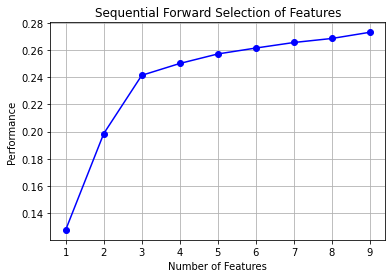

In [35]:
# feature selection
from sklearn.datasets import load_boston

#importing the necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

varNames = list( X.columns.values )
maxCols = X.shape[1]



sfs = SFS(LinearRegression(),
           k_features=( 5, 9 ),
           forward=True,
           floating=False,
           scoring = 'r2',
           cv=3
           )
sfs.fit(X.values, Y.values)


theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('Sequential Forward Selection of Features')
plt.grid()
plt.show()

In [36]:
dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm_names = dfm.columns.values
dfm = dfm[ ['feature_names', 'avg_score'] ]
print( dfm.head(13) )
print("before converting")
dt = dfm.dtypes
print( dt )
dfm.avg_score = dfm.avg_score.astype(float)
print("after converting")
dt = dfm.dtypes
print( dt )

maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")
print(varNames)


                    feature_names avg_score
1                           (14,)  0.127572
2                        (14, 17)  0.198495
3                     (4, 14, 17)  0.241464
4                 (4, 14, 16, 17)  0.250205
5              (4, 6, 14, 16, 17)  0.257211
6           (1, 4, 6, 14, 16, 17)  0.261576
7        (0, 1, 4, 6, 14, 16, 17)  0.265653
8     (0, 1, 2, 4, 6, 14, 16, 17)  0.268622
9  (0, 1, 2, 3, 4, 6, 14, 16, 17)  0.273203
before converting
feature_names    object
avg_score        object
dtype: object
after converting
feature_names     object
avg_score        float64
dtype: object
argmax
feature_names    (0, 1, 2, 3, 4, 6, 14, 16, 17)
avg_score                              0.273203
Name: 9, dtype: object
 ................... 
['start_LD', 'start_CB', 'start_AA', 'start_BC', 'off_num', 'def_num', 'total_off_bordering', 'total_def_bordering', 'def_trailing', 'fourth_quarter_ot', 'third_or_fourth_down', 'under_5_yds_to_go', 'absoluteYardlineNumber', 'defendersInBox', 'pff_pla

In [37]:
vN = ['start_LD', 'start_CB', 'start_AA','start_BC', 'off_num', 'total_off_bordering',
      'pff_playAction', 'Oline', 'adj_x_distance_from_snap']

In [38]:
theScaler = MinMaxScaler()
theScaler.fit( X_train )

MinMaxScaler()

In [39]:
V_train = theScaler.transform( W_train )
V_test = theScaler.transform( W_test )

V_train = pd.DataFrame( V_train )
V_test = pd.DataFrame( V_test )

V_train.columns = list( W_train.columns.values )
V_test.columns = list( W_train.columns.values )

V_train = V_train[ vN ]
V_test = V_test[ vN ]

In [40]:
A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.softplus
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800

A_theUnits = int( 2*A_theShapeSize  )

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

In [41]:
AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

2023-02-07 01:56:44.473445: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-07 01:56:44.653228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [42]:
TRAIN_AMT = getAmtAccuracyScores( "Tensor_FLow_Train", AMT, V_train[vN], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( "Tensor_FLow_Test", AMT, V_test[vN], Z_test[TARGET_A] )
print_Accuracy( "Tensor_FLow Min Distance ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_AMT = TEST_AMT.copy()

Tensor_FLow Min Distance ACCURACY
Tensor_FLow_Train  =  1.5432536574381701
Tensor_FLow_Test  =  1.5285032120241326
-------




In [43]:
W_train['exp_dist_to_qb'] = AMT.predict(V_train[vN])
W_test['exp_dist_to_qb'] = AMT.predict(V_test[vN])

In [44]:
exp_dist_to_qb = pd.concat([W_train['exp_dist_to_qb'], W_test['exp_dist_to_qb']])
final = movement_total_2.merge(exp_dist_to_qb, left_index=True, right_index=True)
final['exp_minus_actual_distance'] = final['exp_dist_to_qb'] - final['distance_from_ball']
players = players_df[['nflId', 'displayName']]
final = final.merge(players, on='nflId')

In [45]:
# 2 seconds
final_2 = final

In [46]:
movement_final_3 = movement_total_2_5.drop(['gameId', 'playId', 'nflId'], axis=1)

TARGET_A = "distance_from_ball"

X = movement_final_3.copy()
X = X.drop( TARGET_A, axis=1)

Y = movement_final_3[ [TARGET_A] ]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state=1)

F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

In [47]:
theScaler = MinMaxScaler()
theScaler.fit( X_train )

MinMaxScaler()

In [48]:
V_train = theScaler.transform( W_train )
V_test = theScaler.transform( W_test )

V_train = pd.DataFrame( V_train )
V_test = pd.DataFrame( V_test )

V_train.columns = list( W_train.columns.values )
V_test.columns = list( W_train.columns.values )

V_train = V_train[ vN ]
V_test = V_test[ vN ]

In [49]:
A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.softplus
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800

A_theUnits = int( 2*A_theShapeSize  )

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

In [50]:
AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

In [51]:
TRAIN_AMT = getAmtAccuracyScores( "Tensor_FLow_Train", AMT, V_train[vN], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( "Tensor_FLow_Test", AMT, V_test[vN], Z_test[TARGET_A] )
print_Accuracy( "Tensor_FLow Min Distance ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_AMT = TEST_AMT.copy()

Tensor_FLow Min Distance ACCURACY
Tensor_FLow_Train  =  2.0038122560345024
Tensor_FLow_Test  =  2.047721163737022
-------




In [52]:
W_train['exp_dist_to_qb'] = AMT.predict(V_train[vN])
W_test['exp_dist_to_qb'] = AMT.predict(V_test[vN])

In [53]:
exp_dist_to_qb = pd.concat([W_train['exp_dist_to_qb'], W_test['exp_dist_to_qb']])
final = movement_total_2_5.merge(exp_dist_to_qb, left_index=True, right_index=True)
final['exp_minus_actual_distance'] = final['exp_dist_to_qb'] - final['distance_from_ball']
players = players_df[['nflId', 'displayName']]
final = final.merge(players, on='nflId')

In [54]:
# 2.5 seconds
final_2_5 = final

In [55]:
movement_final_3 = movement_total_3.drop(['gameId', 'playId', 'nflId'], axis=1)

TARGET_A = "distance_from_ball"

X = movement_final_3.copy()
X = X.drop( TARGET_A, axis=1)

Y = movement_final_3[ [TARGET_A] ]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state=1)

F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

In [56]:
theScaler = MinMaxScaler()
theScaler.fit( X_train )

MinMaxScaler()

In [57]:
V_train = theScaler.transform( W_train )
V_test = theScaler.transform( W_test )

V_train = pd.DataFrame( V_train )
V_test = pd.DataFrame( V_test )

V_train.columns = list( W_train.columns.values )
V_test.columns = list( W_train.columns.values )

V_train = V_train[ vN ]
V_test = V_test[ vN ]

In [58]:
A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.softplus
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800

A_theUnits = int( 2*A_theShapeSize  )

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

In [59]:
AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

In [60]:
TRAIN_AMT = getAmtAccuracyScores( "Tensor_FLow_Train", AMT, V_train[vN], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( "Tensor_FLow_Test", AMT, V_test[vN], Z_test[TARGET_A] )
print_Accuracy( "Tensor_FLow Min Distance ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_AMT = TEST_AMT.copy()

Tensor_FLow Min Distance ACCURACY
Tensor_FLow_Train  =  2.6503229772133285
Tensor_FLow_Test  =  2.784661847033754
-------




In [61]:
W_train['exp_dist_to_qb'] = AMT.predict(V_train[vN])
W_test['exp_dist_to_qb'] = AMT.predict(V_test[vN])

In [62]:
exp_dist_to_qb = pd.concat([W_train['exp_dist_to_qb'], W_test['exp_dist_to_qb']])
final = movement_total_3.merge(exp_dist_to_qb, left_index=True, right_index=True)
final['exp_minus_actual_distance'] = final['exp_dist_to_qb'] - final['distance_from_ball']
players = players_df[['nflId', 'displayName']]
final = final.merge(players, on='nflId')

In [63]:
# 3 seconds
final_3 = final

In [64]:
norm_exp_minus_actual = final_2['exp_minus_actual_distance']
norm_exp_minus_actual = (norm_exp_minus_actual - norm_exp_minus_actual.mean()) / norm_exp_minus_actual.std()
final_2['norm_exp_minus_actual'] = norm_exp_minus_actual

norm_exp_minus_actual = final_2_5['exp_minus_actual_distance']
norm_exp_minus_actual = (norm_exp_minus_actual - norm_exp_minus_actual.mean()) / norm_exp_minus_actual.std()
final_2_5['norm_exp_minus_actual'] = norm_exp_minus_actual

norm_exp_minus_actual = final_3['exp_minus_actual_distance']
norm_exp_minus_actual = (norm_exp_minus_actual - norm_exp_minus_actual.mean()) / norm_exp_minus_actual.std()
final_3['norm_exp_minus_actual'] = norm_exp_minus_actual

In [65]:
# outside EPA data
YEAR = 2021

epa = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(YEAR) + '.csv.gz',
                   compression= 'gzip', low_memory= False)

epa_df = epa[['play_id', 'old_game_id','epa']]
epa_df = epa_df.rename(columns={'play_id':'playId', 'old_game_id':'gameId'})

In [66]:
final_2['sec'] = "2"
final_2_5['sec'] = "2.5"
final_3['sec'] = "3"

f2 = final_2[['gameId', 'playId', 'nflId', 'distance_from_ball', 'sec']]
f2_5 = final_2_5[['gameId', 'playId', 'nflId', 'distance_from_ball', 'sec']]
f3 = final_3[['gameId', 'playId', 'nflId', 'distance_from_ball', 'sec']]

min_from_qb_1 = pd.concat([f2, f2_5, f3]).drop_duplicates()

In [67]:
min_from_qb_2 = min_from_qb_1.merge(movement_rushers_blockers[['gameId', 'playId', 'nflId', 'rush_lane',
                                                               'distance_from_ball']],
                                    on=['gameId', 'playId', 'nflId', 'distance_from_ball']).drop_duplicates()
min_from_qb_2['dist_range'] = np.where(min_from_qb_2['distance_from_ball'] < 3, "0-3yds",
                                      np.where(min_from_qb_2['distance_from_ball'] < 4, "3-4yds",
                                              np.where(min_from_qb_2['distance_from_ball'] < 5, "4-5yds",
                                                      ">5yds")))

In [68]:
mq2 = min_from_qb_2[min_from_qb_2['sec'] == "2"].reset_index(drop=True)
mq2_5 = min_from_qb_2[min_from_qb_2['sec'] == "2.5"].reset_index(drop=True)
mq3 = min_from_qb_2[min_from_qb_2['sec'] == "3"].reset_index(drop=True)


min_dist_2 = mq2.loc[mq2.reset_index(drop=True).groupby(['gameId', 'playId'])['distance_from_ball'].idxmin()]
min_dist_2_5 = mq2_5.loc[mq2_5.reset_index(drop=True).groupby(['gameId', 'playId'])['distance_from_ball'].idxmin()]
min_dist_3 = mq3.loc[mq3.reset_index(drop=True).groupby(['gameId', 'playId'])['distance_from_ball'].idxmin()]

min_from_qb_final = pd.concat([min_dist_2, min_dist_2_5, min_dist_3]).drop_duplicates().reset_index(drop=True)


In [69]:
min_from_qb_final_epa = min_from_qb_final.merge(epa_df, on=['playId', 'gameId'])
min_from_qb_final_epa['sec'] = min_from_qb_final_epa['sec'].astype(str)

In [70]:
med_epa = pd.pivot_table(min_from_qb_final_epa, index=['sec', 'dist_range'], columns=['rush_lane'],
                     values=['epa'], aggfunc=[np.median, 'count']).round(3)
med_epa = med_epa[[('median', 'epa', 'LD'), ('median', 'epa', 'CB'), ('median', 'epa', 'AA'), ('median', 'epa', 'BC'),
       ('median', 'epa', 'RD'), ('count', 'epa', 'LD'), ('count', 'epa', 'CB'), ('count', 'epa', 'AA'),
       ('count', 'epa', 'BC'), ('count', 'epa', 'RD')]]

In [71]:
def highlight_number(row):
    return [
        'background-color: red; color: white' if cell <= 0
        else 'background-color: white; color: black'
        for cell in row
    ]

In [72]:
# med_epa.style \
#     .apply(highlight_number, subset=pd.IndexSlice[:, [('median', 'epa', 'LD'), ('median', 'epa', 'CB'), ('median', 'epa', 'AA'),
#                                      ('median', 'epa', 'BC'), ('median', 'epa', 'RD')]]).format("{:.2f}", subset=pd.IndexSlice[:, [('median', 'epa', 'LD'), ('median', 'epa', 'CB'), ('median', 'epa', 'AA'),
#                                      ('median', 'epa', 'BC'), ('median', 'epa', 'RD')]])

[Text(0.5, 1.0, 'Distribution of Distance to QB at 3 sec')]

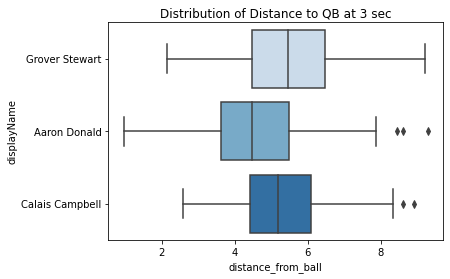

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

dt_3_boxplot = final_2[(final_2['displayName'] == 'Aaron Donald') | (final_2['displayName'] == 'Calais Campbell') |
            (final_2['displayName'] == 'Grover Stewart')][['displayName', 'distance_from_ball']]

sns.boxplot(x=dt_3_boxplot['distance_from_ball'], y=dt_3_boxplot['displayName'], 
            palette="Blues").set(title='Distribution of Distance to QB at 3 sec')
#plt.show()

In [74]:
ind_3 = final_3.groupby('displayName')['norm_exp_minus_actual'].agg([lambda x: np.percentile(x, 50), 'count'])
ind_3 = ind_3.rename({'<lambda_0>': 'Avg Gain vs Exp', 'count': '# Rushes'}, axis=1).sort_values('# Rushes', ascending=False)
ind_3 = ind_3[ind_3['# Rushes'] > 50].sort_values('Avg Gain vs Exp', ascending=False)

over_50_at_3_sec_rushers = ind_3.reset_index()['displayName']

ind_3 = ind_3.merge(over_50_at_3_sec_rushers, on=['displayName']).drop_duplicates()


#ind_rushers = ind_rushers.merge(over_50_at_3_sec_rushers, on=['displayName']).drop_duplicates()

ind_3['Rank'] = [*range(1, ind_3.shape[0] + 1, 1)]
ind_3['sec'] = "3"
ind_3 = ind_3.drop('# Rushes', axis=1)

ind_2_5 = final_2_5.groupby('displayName')['norm_exp_minus_actual'].agg([lambda x: np.percentile(x, 50), 'count'])
ind_2_5 = ind_2_5.rename({'<lambda_0>': 'Avg Gain vs Exp', 'count': '# Rushes'}, axis=1).sort_values('# Rushes', ascending=False)
ind_2_5 = ind_2_5[ind_2_5['# Rushes'] > 50].sort_values('Avg Gain vs Exp', ascending=False)

ind_2_5 = ind_2_5.merge(over_50_at_3_sec_rushers, on=['displayName']).drop_duplicates()

ind_2_5['Rank'] = [*range(1, ind_2_5.shape[0] + 1, 1)]
ind_2_5['sec'] = "2.5"
ind_2_5 = ind_2_5.drop('# Rushes', axis=1)

ind_2 = final_2.groupby('displayName')['norm_exp_minus_actual'].agg([lambda x: np.percentile(x, 50), 'count'])
ind_2 = ind_2.rename({'<lambda_0>': 'Avg Gain vs Exp', 'count': '# Rushes'}, axis=1).sort_values('# Rushes', ascending=False)
ind_2 = ind_2[ind_2['# Rushes'] > 50].sort_values('Avg Gain vs Exp', ascending=False)

ind_2 = ind_2.merge(over_50_at_3_sec_rushers, on=['displayName']).drop_duplicates()

ind_2['Rank'] = [*range(1, ind_2.shape[0] + 1, 1)]
ind_2['sec'] = "2"
ind_2 = ind_2.drop('# Rushes', axis=1)

In [75]:
over_50_at_3_sec_rushers = ind_3.reset_index()['displayName']
#print(over_50_at_3_sec_rushers)

In [76]:
ind_rushers = pd.concat([ind_2, ind_2_5, ind_3])
ind_rushers['Avg Gain vs Exp'] = ind_rushers['Avg Gain vs Exp'].round(2)
ind_rushers = ind_rushers.reset_index()
#ind_rushers = ind_rushers.merge(over_50_at_3_sec_rushers, on=['displayName']).drop_duplicates()
#print(ind_rushers)

In [77]:
ind_pass_rushers = pd.pivot_table(ind_rushers, index=['displayName'], columns=['sec'], values=['Avg Gain vs Exp', 'Rank'])

In [78]:
def highlight_number_2(row):
    return [
        'background-color: green; color: white' if (cell <= 20 and cell > 0.9)
        else 'background-color: white; color: black'
        for cell in row
    ]

In [79]:
# ind_pass_rushers.style \
#     .apply(highlight_number_2, subset=pd.IndexSlice[:, [(           'Rank',   '2'),
#             (           'Rank', '2.5'),
#             (           'Rank',   '3')]]).format("{:.0f}", subset=pd.IndexSlice[:, [(           'Rank',   '2'),
#             (           'Rank', '2.5'),
#             (           'Rank',   '3')]]) \
#     .apply(highlight_number, subset=pd.IndexSlice[:, [('Avg Gain vs Exp',   '2'),
#             ('Avg Gain vs Exp', '2.5'),
#             ('Avg Gain vs Exp',   '3')]]).format("{:.2f}", subset=pd.IndexSlice[:, [('Avg Gain vs Exp',   '2'),
#             ('Avg Gain vs Exp', '2.5'),
#             ('Avg Gain vs Exp',   '3')]])

In [80]:
num_rushers = final_2.groupby(['gameId', 'playId']).size().reset_index()
num_rushers = num_rushers.rename(columns = {0: 'Def Rushers'})

In [81]:
team_beg_2 = min_from_qb_2.merge(final_2[['gameId', 'playId', 'nflId', 'sec', 'norm_exp_minus_actual']],
                                 on=['gameId', 'playId', 'nflId', 'sec']).drop_duplicates()
team_beg_2_5 = min_from_qb_2.merge(final_2_5[['gameId', 'playId', 'nflId', 'sec', 'norm_exp_minus_actual']],
                                 on=['gameId', 'playId', 'nflId', 'sec']).drop_duplicates()
team_beg_3 = min_from_qb_2.merge(final_3[['gameId', 'playId', 'nflId', 'sec', 'norm_exp_minus_actual']],
                                 on=['gameId', 'playId', 'nflId', 'sec']).drop_duplicates()
team_beg = pd.concat([team_beg_2, team_beg_2_5, team_beg_3]).drop_duplicates()

In [82]:
team_beg_2 = team_beg.groupby(['gameId', 'playId', 'sec'])['norm_exp_minus_actual'].agg([np.mean, np.sum]).reset_index()

In [83]:
team_oline = team_beg_2.merge(plays_df[['gameId', 'playId', 'possessionTeam']], on=['gameId', 'playId'])
team_oline = team_oline.merge(num_rushers, on=['gameId', 'playId'])
team_oline['avg_pass_rush_vs_exp'] = round(-1*(team_oline['sum'] / team_oline['Def Rushers']), 2)
#print(team_oline.head())

In [84]:
team_ranks = round(pd.pivot_table(team_oline, index=['possessionTeam'], columns=['sec'],
                                  values=['avg_pass_rush_vs_exp'], aggfunc=[np.mean]),3)
#print(team_ranks.sort_values(by=[('mean', 'avg_pass_rush_vs_exp',   '2')], ascending=False))

In [85]:
team_oline_third_fourth_down = team_oline.merge(plays_pff_count_line[plays_pff_count_line['third_or_fourth_down'] == 1], 
                                               on=['gameId', 'playId']).drop_duplicates()

In [86]:
team_oline_third_fourth_down['under_5_yds_to_go'] = team_oline_third_fourth_down['under_5_yds_to_go'].map({1: '>= 5yds to go',
                                                                                                           0: '< 5yds to go'})

team_oline_third_fourth_down = team_oline_third_fourth_down.rename(columns={'under_5_yds_to_go':'3rd/4th Distance'})
#print(team_oline_third_fourth_down)

In [87]:
team_third_down = pd.pivot_table(team_oline_third_fourth_down, index=['possessionTeam'], columns=['3rd/4th Distance', 'sec'], 
                     values=['avg_pass_rush_vs_exp'], aggfunc=[np.mean]),3

In [88]:
round(team_ranks.sort_values(by=[('mean', 'avg_pass_rush_vs_exp',   '2')], ascending=False),2).style.apply(highlight_number).format("{:.2f}")

In [89]:
round(pd.pivot_table(team_oline_third_fourth_down, index=['possessionTeam'], columns=['3rd/4th Distance', 'sec'], 
                     values=['avg_pass_rush_vs_exp'], aggfunc=[np.mean]),2).style.apply(highlight_number).format("{:.2f}")